In [341]:
import pyspark
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession 
from pyspark.ml.stat import Correlation
import pyspark.sql.functions as F

conf = pyspark.SparkConf().setAppName('appName').setMaster('local')
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession(sc)

In [342]:
spark

In [343]:
df = spark.read.csv("scaled_data.csv", inferSchema=True,header=True)

In [344]:
from pyspark.ml.linalg import Vector
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import monotonically_increasing_id
import matplotlib.pyplot as plt

In [345]:
# Vector Assembler

assembler = VectorAssembler(inputCols=['Production','Annual_Rainfall','Fertilizer','Pesticide','Area','Crop','Crop_Year','Season','State'],outputCol='features')
output= assembler.transform(df)
final_data=output.select('features','Yield')
final_data.head(5)

In [349]:
# Setting the tolerance level

tolerance = 1.5

# Model 1

In [350]:
# Splitting the data and training the model

train_data1,test_data1=final_data.randomSplit([0.7,0.3], seed=13) 
lr1 =LinearRegression(featuresCol='features',labelCol='Yield')
model1=lr1.fit(train_data1)
results1 = model1.evaluate(train_data1)
print('R2 Score on Training Data:',results1.r2)
print('Root Mean Squared Error on Training Data:',(results1.meanSquaredError**(1/2)))
print('Mean Absolute Error on Training Data:',results1.meanAbsoluteError)


R2 Score on Training Data: 0.4439153195842994
Root Mean Squared Error on Training Data: 0.755819886522101
Mean Absolute Error on Training Data: 0.6111732543724151


In [351]:
# Combining actual and predicted yield in a single PySpark dataframe

unlabeled_data1=test_data1.select('features')
preds1=model1.transform(unlabeled_data1)
preds1 = preds1.select('prediction')
actual1 = test_data1.select('Yield')
preds1 = preds1.withColumn("index", monotonically_increasing_id())
actual1 = actual1.withColumn("index", monotonically_increasing_id())
preds_labels1 = preds1.join(actual1, on="index").drop("index")
print(preds_labels1.head(5))


[Row(prediction=1.3267965164997442, Yield=0.3462870368), Row(prediction=0.8434081468578114, Yield=0.48), Row(prediction=1.0072136031498182, Yield=1.64), Row(prediction=1.1120173713001904, Yield=1.44), Row(prediction=1.1267789382292506, Yield=1.45)]


In [352]:
# Evaluating the results using accuracy, R2 Score, RMSE and MAE metrics

evaluator1 = RegressionEvaluator(labelCol="Yield", predictionCol="prediction", metricName="r2")
r21 = evaluator1.evaluate(preds_labels1)
evaluator1.setMetricName("mse")
mse1 = evaluator1.evaluate(preds_labels1)
evaluator1.setMetricName("mae")
mae1 = evaluator1.evaluate(preds_labels1)

within_tolerance1 = preds_labels1.filter(abs(preds_labels1.prediction - preds_labels1.Yield) <= tolerance)
correct_predictions1 = within_tolerance1.count()
total_predictions1 = preds_labels1.count()
accuracy1 = (correct_predictions1 / total_predictions1) * 100

print("Accuracy within the", tolerance, "tolerance =", accuracy1)
print('R2 Score on Testing Data:',r21)
print('Root Mean Squared Error on Testing Data:',(mse1**(1/2)))
print('Mean Absolute Error on Testing Data:',mae1)


Accuracy within the 1.5 tolerance = 94.85684896279788
R2 Score on Testing Data: 0.4330610098161689
Root Mean Squared Error on Testing Data: 0.7682905619280963
Mean Absolute Error on Testing Data: 0.6249566431528838


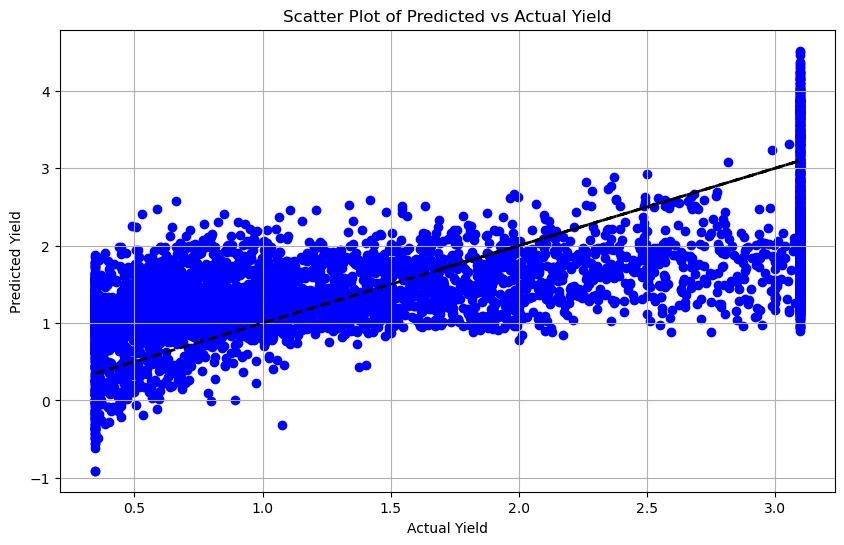

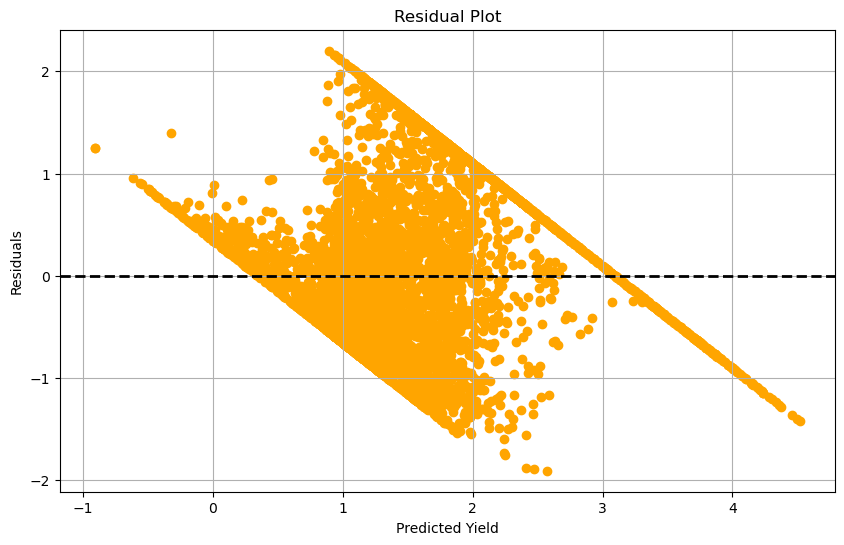

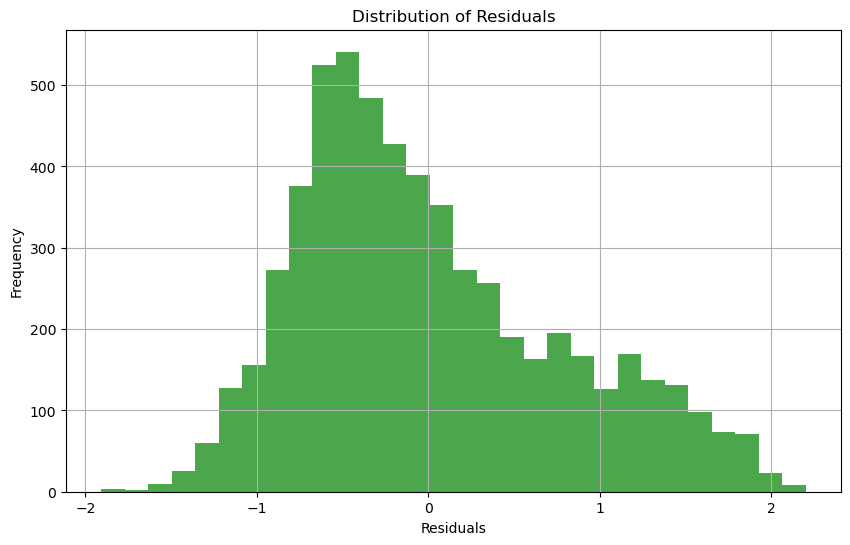

In [353]:
# Visualization of results ---------------------------->

# Scatter plot of Predicted vs Actual values
plt.figure(figsize=(10, 6))
plt.scatter(preds_labels1.select("Yield").toPandas(),preds_labels1.select("prediction").toPandas(), color='blue')
plt.plot(preds_labels1.select("Yield").toPandas(), preds_labels1.select("Yield").toPandas(), 'k--', lw=2)  # this part plots a diagonal line that represents perfect predictions
plt.xlabel('Actual Yield')
plt.ylabel('Predicted Yield')
plt.title('Scatter Plot of Predicted vs Actual Yield')
plt.grid(True)
plt.show()

# Residual Plot
residuals1 = np.array(preds_labels1.select("Yield").toPandas()) - np.array(preds_labels1.select("prediction").toPandas())
plt.figure(figsize=(10, 6))
plt.scatter(preds_labels1.select("prediction").toPandas(), residuals1, color='orange')
plt.xlabel('Predicted Yield')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True)
plt.axhline(y=0, color='k', linestyle='--', linewidth=2)
plt.show()

# Distribution of Residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals1, bins=30, color='green', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.grid(True)
plt.show()

# Model 2

In [354]:
# Splitting the data and training the model

train_data2,test_data2=final_data.randomSplit([0.8,0.2], seed=20) 
lr2 =LinearRegression(featuresCol='features',labelCol='Yield')
model2=lr2.fit(train_data2)
results2 = model2.evaluate(train_data2)
print('R2 Score on Training Data:',results2.r2)
print('Root Mean Squared Error on Training Data:',(results1.meanSquaredError**(1/2)))
print('Mean Absolute Error on Training Data:',results2.meanAbsoluteError)


R2 Score on Training Data: 0.443361411868999
Root Mean Squared Error on Training Data: 0.755819886522101
Mean Absolute Error on Training Data: 0.6133457752634078


In [355]:
# Combining actual and predicted yield in a single PySpark dataframe

unlabeled_data2=test_data2.select('features')
preds2=model2.transform(unlabeled_data2)
preds2 = preds2.select('prediction')
actual2 = test_data2.select('Yield')
preds2 = preds2.withColumn("index", monotonically_increasing_id())
actual2 = actual2.withColumn("index", monotonically_increasing_id())
preds_labels2 = preds2.join(actual2, on="index").drop("index")

In [356]:
# Evaluating the results using accuracy, R2 Score, RMSE and MAE metrics

evaluator2 = RegressionEvaluator(labelCol="Yield", predictionCol="prediction", metricName="r2")
r22 = evaluator2.evaluate(preds_labels2)
evaluator2.setMetricName("mse")
mse2 = evaluator2.evaluate(preds_labels2)
evaluator2.setMetricName("mae")
mae2 = evaluator2.evaluate(preds_labels2)

within_tolerance2 = preds_labels2.filter(abs(preds_labels2.prediction - preds_labels2.Yield) <= tolerance)
correct_predictions2 = within_tolerance2.count()
total_predictions2 = preds_labels2.count()
accuracy2 = (correct_predictions2 / total_predictions2) * 100

print("Accuracy within the", tolerance, "tolerance =", accuracy2)
print('R2 Score on Testing Data:',r22)
print('Root Mean Squared Error on Testing Data:',(mse2**(1/2)))
print('Mean Absolute Error on Testing Data:',mae2)

Accuracy within the 1.5 tolerance = 94.9234693877551
R2 Score on Testing Data: 0.4300865832465771
Root Mean Squared Error on Testing Data: 0.7680773771248687
Mean Absolute Error on Testing Data: 0.621216412171684


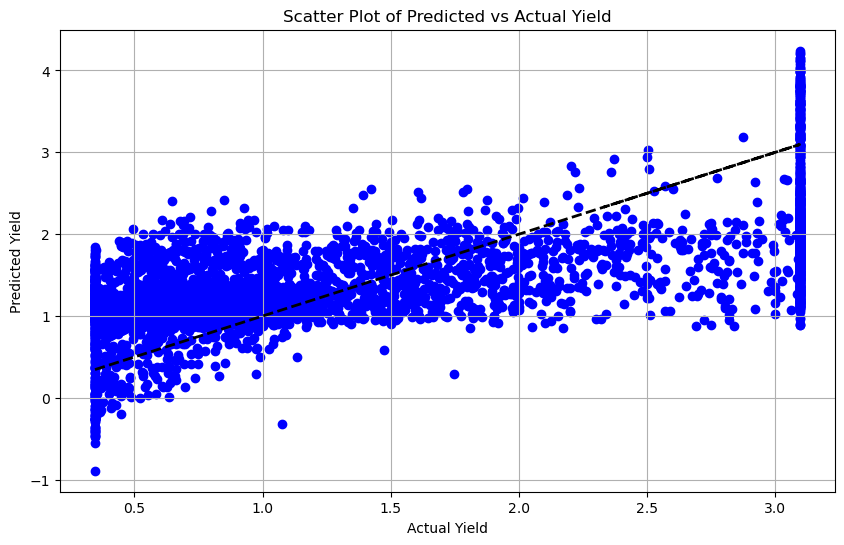

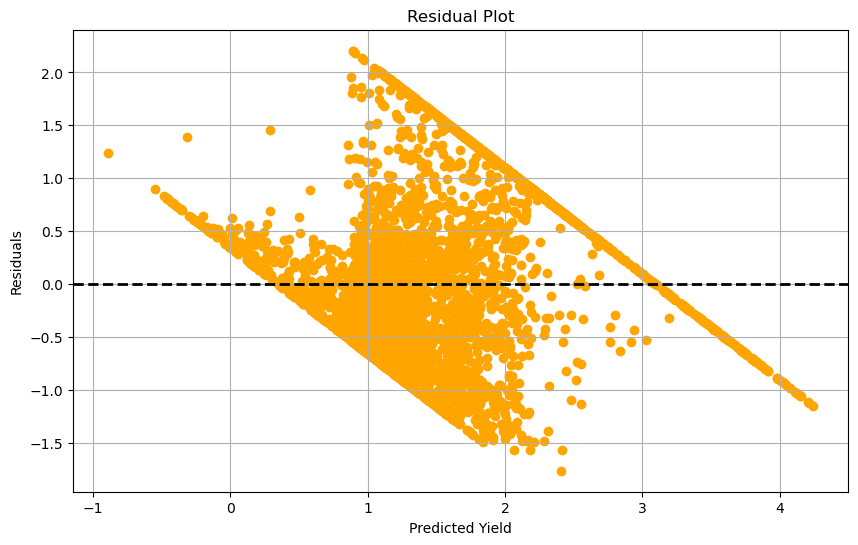

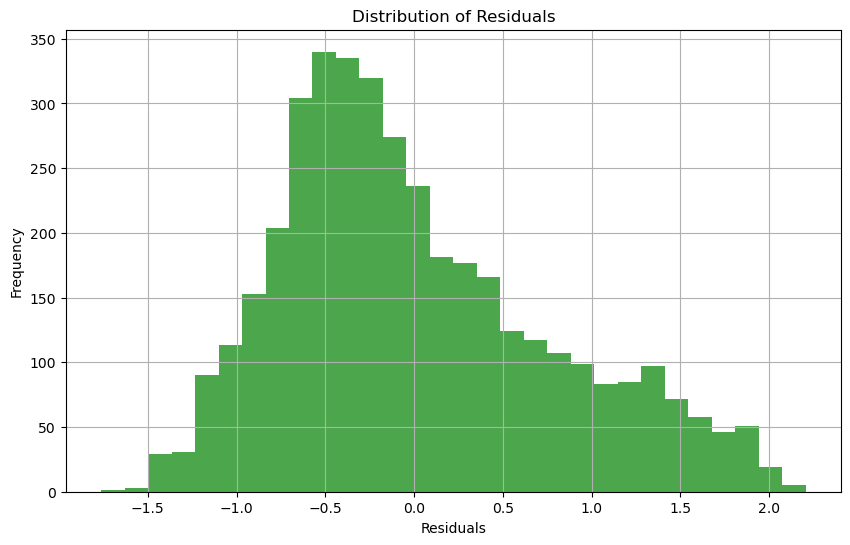

In [357]:
# Visualization of results ---------------------------->

# Scatter plot of Predicted vs Actual values
plt.figure(figsize=(10, 6))
plt.scatter(preds_labels2.select("Yield").toPandas(),preds_labels2.select("prediction").toPandas(), color='blue')
plt.plot(preds_labels2.select("Yield").toPandas(), preds_labels2.select("Yield").toPandas(), 'k--', lw=2)  # this part plots a diagonal line that represents perfect predictions
plt.xlabel('Actual Yield')
plt.ylabel('Predicted Yield')
plt.title('Scatter Plot of Predicted vs Actual Yield')
plt.grid(True)
plt.show()

# Residual Plot
residuals2 = np.array(preds_labels2.select("Yield").toPandas()) - np.array(preds_labels2.select("prediction").toPandas())
plt.figure(figsize=(10, 6))
plt.scatter(preds_labels2.select("prediction").toPandas(), residuals2, color='orange')
plt.xlabel('Predicted Yield')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True)
plt.axhline(y=0, color='k', linestyle='--', linewidth=2)
plt.show()

# Distribution of Residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals2, bins=30, color='green', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.grid(True)
plt.show()

# Model 3

In [358]:
# Splitting the data and training the model

train_data3,test_data3=final_data.randomSplit([0.9,0.1], seed=20)
lr3 =LinearRegression(featuresCol='features',labelCol='Yield')
model3=lr3.fit(train_data3)
results3 = model3.evaluate(train_data3)
print('R2 Score on Training Data:',results3.r2)
print('Root Mean Squared Error on Training Data:',(results1.meanSquaredError**(1/2)))
print('Mean Absolute Error on Training Data:',results3.meanAbsoluteError)


R2 Score on Training Data: 0.4425391607100423
Root Mean Squared Error on Training Data: 0.755819886522101
Mean Absolute Error on Training Data: 0.6147045836406968


In [359]:
# Combining actual and predicted yield in a single PySpark dataframe

unlabeled_data3=test_data3.select('features')
preds3=model3.transform(unlabeled_data3)
preds3 = preds3.select('prediction')
actual3 = test_data3.select('Yield')
preds3 = preds3.withColumn("index", monotonically_increasing_id())
actual3 = actual3.withColumn("index", monotonically_increasing_id())
preds_labels3 = preds3.join(actual3, on="index").drop("index")


In [360]:
# Evaluating the results using accuracy, R2 Score, RMSE and MAE metrics

evaluator3 = RegressionEvaluator(labelCol="Yield", predictionCol="prediction", metricName="r2")
r23 = evaluator3.evaluate(preds_labels3)
evaluator3.setMetricName("mse")
mse3 = evaluator3.evaluate(preds_labels3)
evaluator3.setMetricName("mae")
mae3 = evaluator3.evaluate(preds_labels3)

within_tolerance3 = preds_labels3.filter(abs(preds_labels3.prediction - preds_labels3.Yield) <= tolerance)
correct_predictions3 = within_tolerance3.count()
total_predictions3 = preds_labels3.count()
accuracy3 = (correct_predictions3 / total_predictions3) * 100

print("Accuracy within the", tolerance, "tolerance =", accuracy3)
print('R2 Score on Testing Data:',r23)
print('Root Mean Squared Error on Testing Data:',(mse3**(1/2)))
print('Mean Absolute Error on Testing Data:',mae3)

Accuracy within the 1.5 tolerance = 94.83938915218536
R2 Score on Testing Data: 0.42355426348071823
Root Mean Squared Error on Testing Data: 0.7643282093845974
Mean Absolute Error on Testing Data: 0.6166981040827194


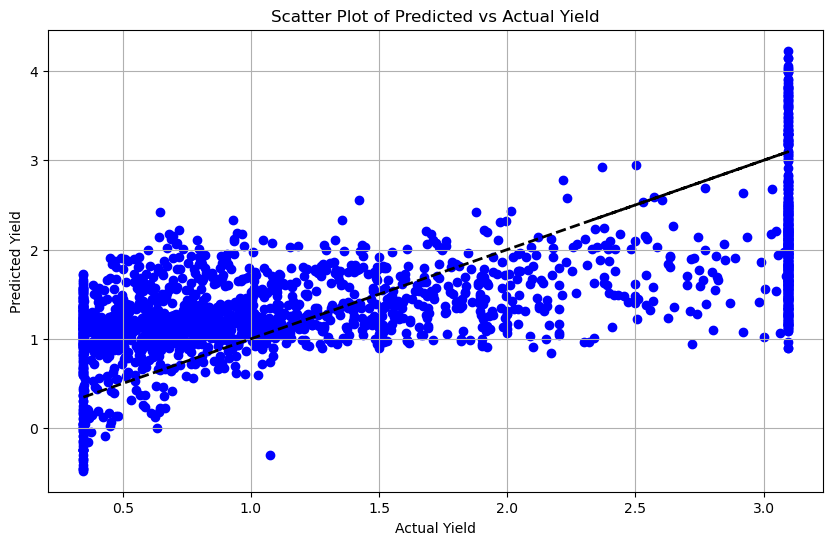

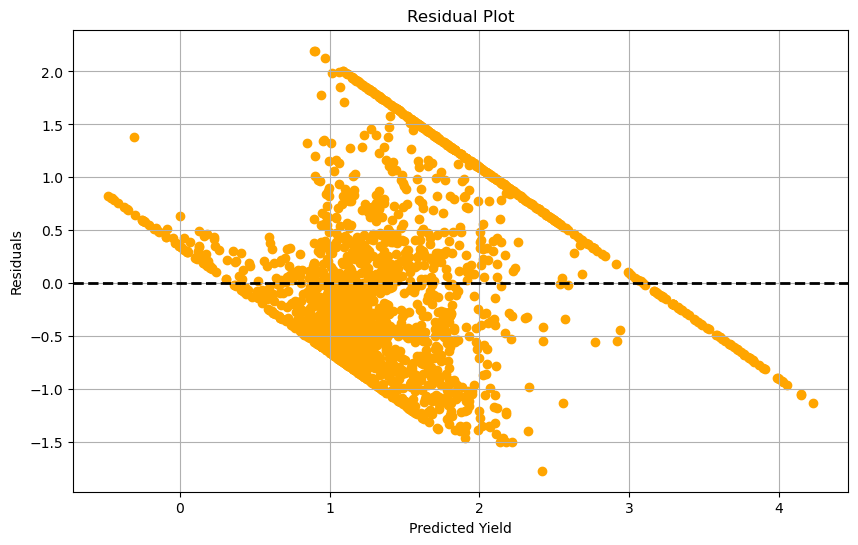

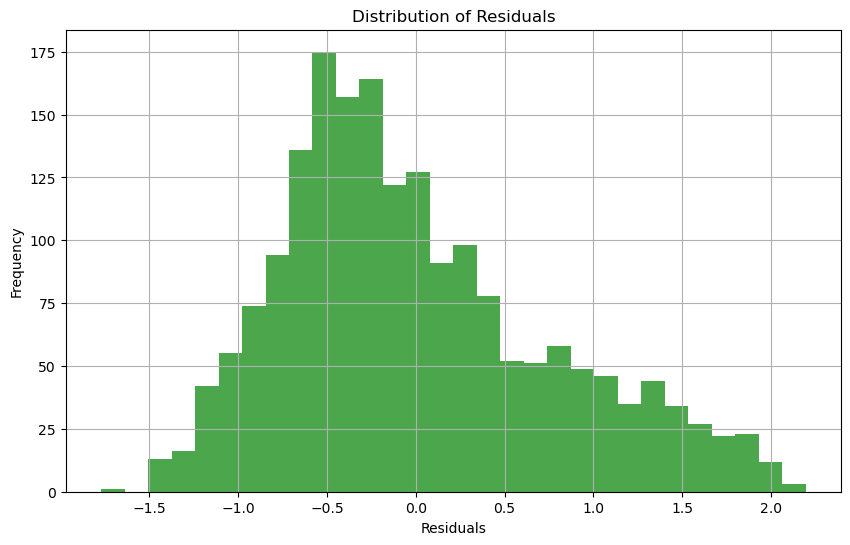

In [361]:
# Visualization of results ---------------------------->

# Scatter plot of Predicted vs Actual values
plt.figure(figsize=(10, 6))
plt.scatter(preds_labels3.select("Yield").toPandas(),preds_labels3.select("prediction").toPandas(), color='blue')
plt.plot(preds_labels3.select("Yield").toPandas(), preds_labels3.select("Yield").toPandas(), 'k--', lw=2)  # this part plots a diagonal line that represents perfect predictions
plt.xlabel('Actual Yield')
plt.ylabel('Predicted Yield')
plt.title('Scatter Plot of Predicted vs Actual Yield')
plt.grid(True)
plt.show()

# Residual Plot
residuals3 = np.array(preds_labels3.select("Yield").toPandas()) - np.array(preds_labels3.select("prediction").toPandas())
plt.figure(figsize=(10, 6))
plt.scatter(preds_labels3.select("prediction").toPandas(), residuals3, color='orange')
plt.xlabel('Predicted Yield')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True)
plt.axhline(y=0, color='k', linestyle='--', linewidth=2)
plt.show()

# Distribution of Residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals3, bins=30, color='green', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.grid(True)
plt.show()

In [375]:
sc.stop()